# Day 14 NDWI and k-means to classify Amazon imagery to identify water

### 0. Libraries required

In [61]:
# system libraries
from pathlib import Path
import os
#standard libraries
import numpy as np
# get imagery libraries
from sentinelsat import SentinelAPI
# geospatial libraries
from osgeo import gdal
import rasterio
from rasterio.plot import show
from affine import Affine
# visualisation libraries
import matplotlib.pyplot as plt
#machine learning libraries
from sklearn import cluster

%matplotlib inline

### 1. Set up data path

In [2]:
path = Path('../data/rivers_amazon_data/ndwi_test/')

2. Download the Sentinel image, extract bands as tifs and store seperately.

The uuid is taken from https://scihub.copernicus.eu/dhus/#/home

In [ ]:
# username = os.environ.get('COPERNICUS_USERNAME')
# password = os.environ.get('COPERNICUS_PASSWORD')
# api = SentinelAPI(user=username, password=password)
# api.download('dcab558f-9b8d-4935-99d5-881144e17348', path)
# product_id = (str(list(path.glob('*'))).split('/')[-1])[:-7];
# ! unzip {path}/{product_id + '.zip'} -d {path}

# parts = [product_id + '.SAFE', 
#         'GRANULE',
#         'L1C_T21MYS_A016080_20180721T140053',
#         'IMG_DATA']

# for i in [2,3,4,8]:
#     image_band = 'T21MYS_20180721T140051_B0{}.jp2'.format(i)
#     filepath = str(path.joinpath(*parts).joinpath(image_band))
#     out_location = str(path) + ('/ndwi_B0{}'.format(i)) + '.tif'
#     src = gdal.Open(filepath)
#     gdal.Translate(out_location, src)

Now that I have the 4 10m bands for S2 imagery stack them.

### 3. Create a False color image. 

Following instruction from [Geoprocessing in python](https://learning.oreilly.com/library/view/geoprocessing-with-python/9781617292149/kindle_split_017.html) - copying the xsize, ysize, projection, geotransform, datatype from the input create a numpy array and copy the selected Sentinel data into it. 

Ensure that the data have been written to disk instead of only cached in memory, so that’s what the call to FlushCache does. Then you loop through the bands and compute the statistics for each one. Passing False to this function tells it that you want actual statistics instead of estimates

Because these pixel values are continuous data, you use average interpolation instead of the default of nearest-neighbor. 

In [ ]:
band1_fn = str(path.joinpath('ndwi_B08.tif')) #NIR
band2_fn = str(path.joinpath('ndwi_B02.tif')) #Green
band3_fn = str(path.joinpath('ndwi_B03.tif')) #Blue

in_ds = gdal.Open(band1_fn)
in_band = in_ds.GetRasterBand(1)
gtiff_driver = gdal.GetDriverByName('GTiff')
out_path = str(path) + '/false_color.tif'
out_ds = gtiff_driver.Create(out_path, in_band.XSize,
                            in_band.YSize, 3, in_band.DataType)
out_ds.SetProjection(in_ds.GetProjection())
out_ds.SetGeoTransform(in_ds.GetGeoTransform())

in_data = in_band.ReadAsArray()
out_band = out_ds.GetRasterBand(1)
out_band.WriteArray(in_data)

out_ds.GetRasterBand(2).WriteArray(gdal.Open(band2_fn).ReadAsArray())
out_ds.GetRasterBand(3).WriteArray(gdal.Open(band3_fn).ReadAsArray())

out_ds.FlushCache()
for i in range(1,4):
    out_ds.GetRasterBand(i).ComputeStatistics(False)
out_ds.BuildOverviews('average', [2,3,8,16,32])

del out_ds

### 4. Take a crop of the full tif to experiment

In [5]:
with rasterio.open(str(path) + '/false_color.tif') as src:
    im = src.read()
    meta = src.meta

In [46]:
image_chip = im[:, 1500:4000, 7000:9500]; image_chip.shape

(3, 2500, 2500)

In [51]:
aff = meta['transform']
newaff = Affine(aff.a, aff.b, aff.c + (7000*10),
                aff.d, aff.e, aff.f + (-1500*10))
out_meta = meta.copy()
out_meta.update({'driver': 'GTiff',
                'height': image_chip.shape[1],
                'width': image_chip.shape[2],
                'count': 3,
                'dtype': 'uint16',
                'transform': newaff})

out_tif_chip = path.joinpath('ndwi_chip')
with rasterio.open(out_tif_chip, 'w', **out_meta) as dst:
        dst.write(image_chip)

### 5. Calculate Normalised Difference Water Index. 

The NDWI is derived from the Near-Infrared (NIR) and green channels (McFeeters 1996):
NDWI (McFeeters) = (Green-NIR) / (Green+NIR)
 
The NDWI is efficient to detect surface water because these surfaces have a very low reflectance in the NIR region of the spectra - in contrast to the vegetation which is characterized by a high reflectance in the NIR.

- [This is a nice blog about ndvi.](http://ceholden.github.io/open-geo-tutorial/python/chapter_3_visualization.html)
- [Useful for sorting out numpy values for zero division](https://automating-gis-processes.github.io/CSC18/lessons/L6/raster-calculations.html) - this could be useful (or something similar) for full image edges where there is nodata as zeros

In [52]:
with rasterio.open(out_tif_chip) as src:
    im = src.read()
    meta = src.meta

In [53]:
nir = im[0]
green = im[1]

In [56]:
ndwi = (green-nir)/(green+nir)

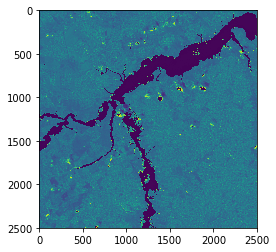

In [59]:
show(ndwi);

### 4. k-means on ndwi image

In [63]:
X = ndwi.reshape((-1,1))

In [65]:
k_means = cluster.KMeans(n_clusters=5)
_ = k_means.fit(X)

In [100]:
X_ndwi = k_means.labels_
X_ndwi = X_ndwi.reshape(1, 2500, 2500)

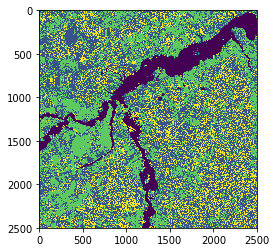

In [111]:
show(X_ndwi);

In [103]:
out_meta = meta.copy()
out_meta.update({'driver': 'GTiff',
                'height': X_ndwi.shape[1],
                'width': X_ndwi.shape[2],
                'count': 1,
                'dtype': 'int32',
                'transform': newaff})
out_tif_ndwi = path.joinpath('k_means_ndwi.tif')

In [104]:
with rasterio.open(out_tif_ndwi, 'w', **out_meta) as dst:
    dst.write(X_ndwi)